# Esercizio 1.A
L'esercizio prevede la costruzione di un  generatore di caption di immagini.\
Utilizzando il tool preferito, costruire una CNN in grado di costruire un suitable embedding di un immagine, il quale verrà passato ad una RNN per la generazione del testo della caption.\
Per il training utilizzare il [Flickr Dataset](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset)

In [1]:
import os;
os.environ['KERAS_BACKEND'] = 'jax'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

flickr = 'flickr30k'
display_test = 5

## Imports & function declarations

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from numpy import int32
from keras.api import layers
from keras.api.utils import plot_model
from keras.api.applications import Xception as PretrainedNN
from keras.api.callbacks import EarlyStopping
from keras.api.models import Model, Sequential
from keras.api.preprocessing.sequence import pad_sequences


def build_sentence(y:np.ndarray, y_ohe:np.ndarray, map:dict[str, int]):
    inv_map = {v: k for k, v in map.items()}
    inv_map[0] = ''
    string = ''

    for id in y: string += ' ' + inv_map[id]
    string += ' ' + inv_map[np.argmax(y_ohe)]

    return string

def load_image(image_path:str):
    with Image.open(image_path) as image:
        image = image.resize((224, 224))
        return np.array(image) / 255

def process_images(images_names:np.ndarray, path:str):
    pretrain = Sequential([
        PretrainedNN(include_top=False),
        layers.GlobalAveragePooling2D()
    ])

    shape = (len(images_names), pretrain.output_shape[1])
    images = np.empty(shape)

    for i, name in enumerate(tqdm(images_names, desc="Loading images")):
        image = load_image(path + name)
        image = pretrain.predict(np.array([image]), verbose=0)
        images[i] = image[0]
    return images

def process_captions(text:pd.Series, repeat:int=5):
    word_index = dict()
    word_index['<start>'] = 1
    index = 2

    # building dict for indexing words
    for row in text:
        for word in row.split():
            if word not in word_index:
                word_index[word] = index
                index += 1

    # trainsofrming all sentences into indices
    captions = []
    max_len = 0
    for row in text:
        sequence = [1] + [word_index[word] for word in row.split()]
        max_len = max(max_len, len(sequence))
        captions.append(sequence)

    total_y = sum(len(row) - 1 for row in captions)
    max_len += 2 # adding image and value to predict
    y = np.empty(shape=(total_y, max_len), dtype=int32)
    total_y = 0

    for i, row in enumerate(tqdm(captions, 'Loading captions')):
        end = len(row) - 1

        predict = row[1:]
        row = np.tile([row], (end, 1))
        row = np.tril(row)
        row = pad_sequences(row, max_len, padding='post')

        row[:,-2] = predict
        row[:,-1] = i // repeat

        y[total_y : total_y+end] = row
        total_y += end

    return y, word_index, index, max_len-2

def split_captions_test(x:np.ndarray, y:np.ndarray, frac:float = 0.2):
    total = int(len(x) * frac)
    rands = np.random.choice(len(x), total, replace=False)
    rands = np.sort(rands)
    rands = np.isin(y[:, -1], rands)

    y_train = y[~rands]
    y_test  = y[rands]
    return y_train, y_test

def data_generator(x_data:np.ndarray, y_data:np.ndarray, total_words:int, batch:int=200):
    num_samples = y_data.shape[0]
    steps_batch = num_samples // batch
    yield steps_batch

    randoms = np.arange(num_samples)
    while True:
        np.random.shuffle(randoms)
        indices = np.array_split(randoms, steps_batch)

        for ind in indices:
            y_batch = y_data[ind]

            x_indices = y_batch[:, -1:]
            x_batch = x_data[x_indices[:,0]]
            y_ohe = y_batch[:,-2:-1].astype(int) # not necessary ohe with sparse_categorical
            y_batch = y_batch[:, :-2]

            yield [x_batch, y_batch], y_ohe

## Dataset

In [3]:
dataset_path = '.datasets/'+ flickr + '/'
dataset_images_path = dataset_path + 'images/'
cache_file = dataset_path + 'preprocessed.data.npz'

try:
    values = np.load(cache_file, allow_pickle=True)
    x = values['x']
    y = values['y']
    display_test = values['display_test']
    word_index = values['word_index'].item()
    max_length = values['max_length'].item()
    total_words = values['total_words'].item()
except:
    try:
        dataset = pd.read_csv(dataset_path + 'captions.csv')
    except:
        print('Dataset form ' + flickr + ' not found, download it and store it into: ' + dataset_path)
        exit()

    images = dataset['image_name'].unique()
    x = process_images(images, dataset_images_path)

    text = dataset['comment'].str.lower()
    repeat = len(text) // len(x)
    x, text = x[display_test:], text[display_test * repeat:]
    y, word_index, total_words, max_length = process_captions(text, repeat)

    display_test=images[:display_test]
    np.savez(cache_file, x=x, y=y, word_index=word_index, total_words=total_words, max_length=max_length, display_test=display_test)

## Model

2024-09-06 16:44:32.551807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 16:44:32.561981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 16:44:32.565019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


22,930,531


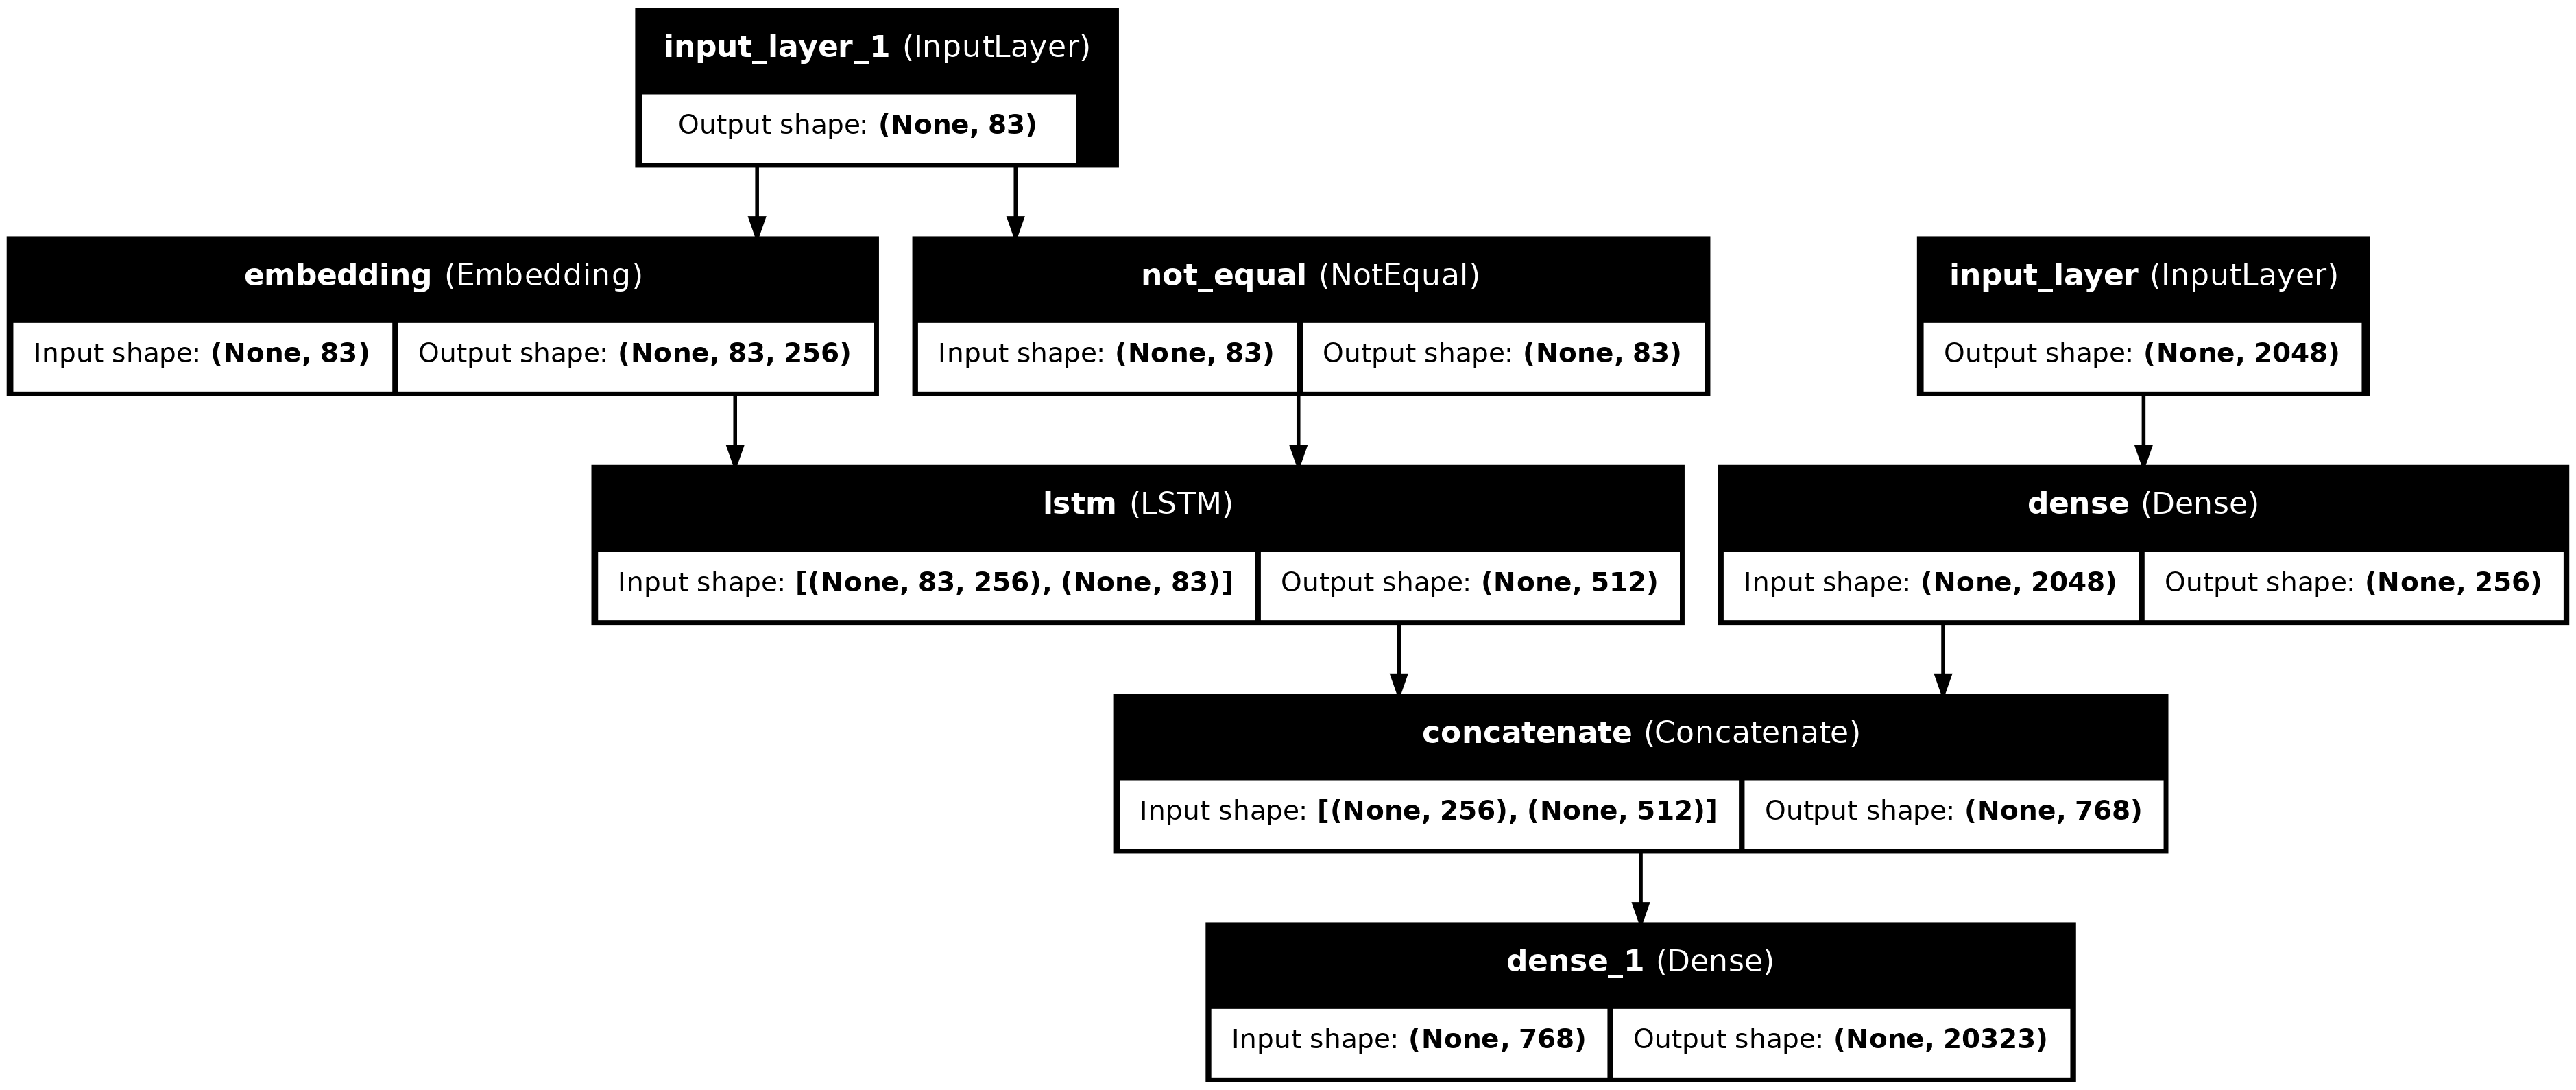

In [4]:
# https://www.inovex.de/de/blog/end-to-end-image-captioning/
# the images are already preprocessed, so it is useless to use vgg again.

image_shape = (x.shape[-1],)
caption_shape = (max_length,)
dictionary_size = total_words
embed = 256
dense = 256
units = dense + embed

image_i = layers.Input(shape=image_shape)
image_o = layers.Dense(dense, activation='relu')(image_i)

caption_i = layers.Input(shape=caption_shape)
caption_o = layers.Embedding(dictionary_size, embed, mask_zero=True)(caption_i)

decoder_o = layers.LSTM(units, dropout=0.5, recurrent_dropout=0.3)(caption_o)
decoder_o = layers.Concatenate(axis=-1)([image_o, decoder_o])
decoder_o = layers.Dense(dictionary_size, activation='softmax')(decoder_o)

model = Model(inputs=[image_i, caption_i], outputs=decoder_o)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.save('model_caption.keras')

print(f"{model.count_params():,}")
plot_model(model, to_file='model_caption.png', show_shapes=True, show_layer_names=True)
#raise Exception("woof")

## Training

In [5]:
batch = 1000
epochs = 50

y_train, y_test = split_captions_test(x, y, frac=0.05)

train = data_generator(x, y_train, batch=batch, total_words=total_words)
test = data_generator(x, y_test, batch=batch, total_words=total_words)

train_step = next(train)
test_step = next(test)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)
history = model.fit(train, epochs=epochs, steps_per_epoch=train_step, validation_data=test, validation_steps=test_step, callbacks=[earlystopping])

Epoch 1/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 220s 106ms/step - accuracy: 0.2833 - loss: 4.3359 - val_accuracy: 0.3682 - val_loss: 3.2873
Epoch 2/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 200s 98ms/step - accuracy: 0.3826 - loss: 3.0193 - val_accuracy: 0.3824 - val_loss: 3.1873
Epoch 3/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 248s 123ms/step - accuracy: 0.4063 - loss: 2.7417 - val_accuracy: 0.3845 - val_loss: 3.1766
Epoch 4/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 262s 130ms/step - accuracy: 0.4245 - loss: 2.5742 - val_accuracy: 0.3867 - val_loss: 3.1958
Epoch 5/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 256s 127ms/step - accuracy: 0.4377 - loss: 2.4616 - val_accuracy: 0.3859 - val_loss: 3.2281
Epoch 6/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 251s 124ms/step - accuracy: 0.4492 - loss: 2.3726 - val_accuracy: 0.3851 - val_loss: 3.2583
Epoch 7/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 220s 109ms/step - accuracy: 0.4583 - loss: 2.3101 - val_accuracy: 0.3847 - val_loss: 3.2909
Epoch 8/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 233s 115ms/step - acc

## Display

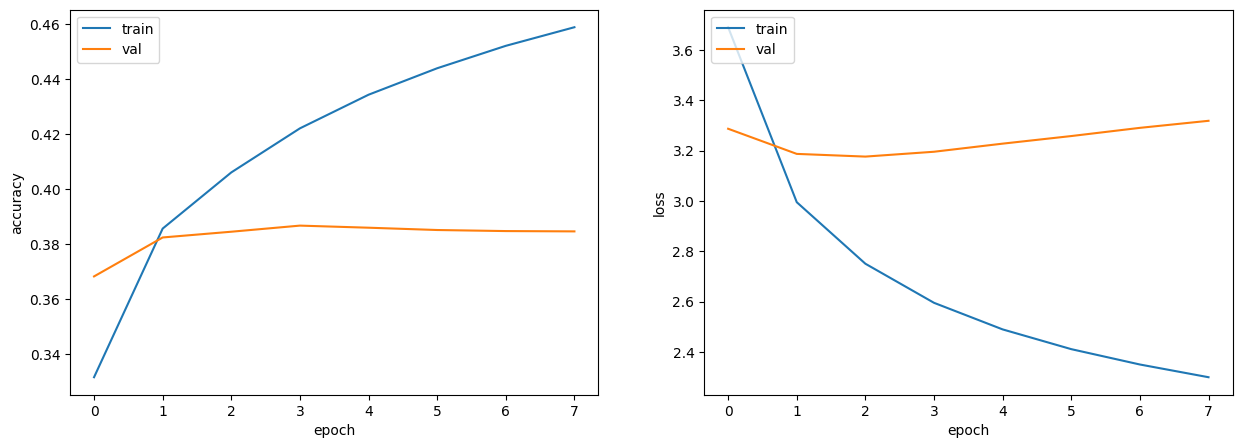

In [6]:
history = model.history

f, ax = plt.subplots(1, 2)
f.set_size_inches(15, 5)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()

## Tests

Loading images: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


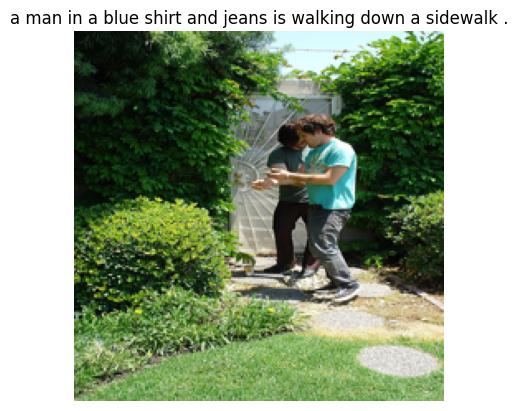

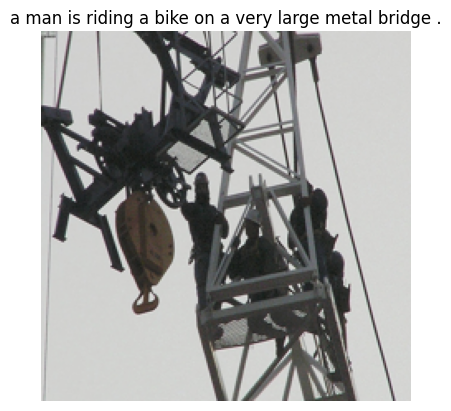

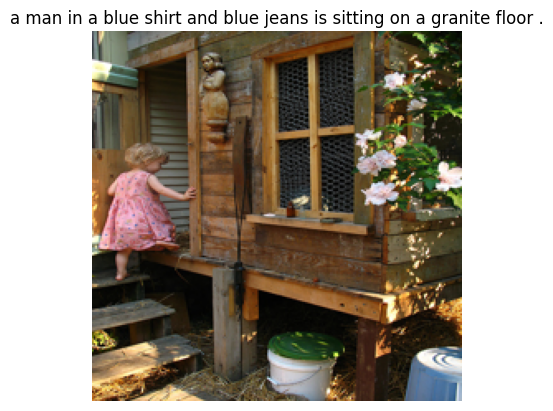

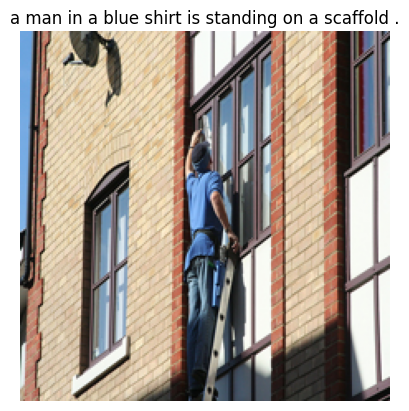

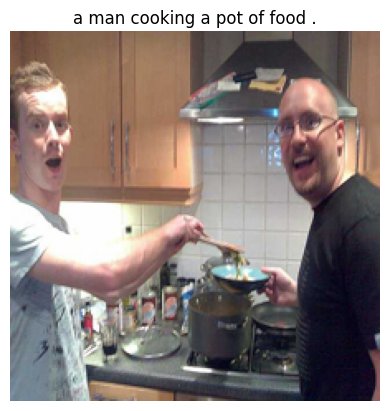

In [7]:
def get_text(text:np.ndarray):
    index_to_word = {v: k for k, v in word_index.items()}
    captions = []
    for i in range(len(text)):
        current = ''
        for index in text[i]:
            if index > 1:
                word = index_to_word[index]
                current += ' ' + index_to_word[index]
                if word == '.': break
        captions.append(current.strip())
    return captions

def display_images(images:np.ndarray, text:list[str]):
    for i in range(len(images)):
        plt.imshow(load_image(dataset_images_path + images[i]))
        plt.title(text[i])
        plt.axis('off')
        plt.show()

image_test = process_images(display_test, dataset_images_path)
text = np.zeros((len(image_test), max_length))
text [:, 0] = 1

for i in range(1, max_length):
    words = model.predict([image_test, text], verbose=0)
    text[:, i] = np.argmax(words, axis=1)
display_images(display_test, get_text(text))